In [1]:
%%javascript
// Making sure the outputs display correctly
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [15]:
# Importing required packages for this homework
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
#from IPython.display import HTML, display
#import tabulate
%matplotlib inline

def rounds(item):
    ret = float('%.3f'% (item * 1000/1000))
    return(ret)

In [3]:
# Atmospheric model created using the NASA equation found at:
# https://www.grc.nasa.gov/WWW/k-12/airplane/atmosmet.html
class atmosphere:
    def __init__(self, val, valGiven = 0,units = "SI"):
        #Convert from US to SI
        if units != "SI" and valGiven == 0:
            val = val / 3.281
        if units != "SI" and valGiven == 1:
            val = val * 0.04788
        #0 implies the given value is an altitude
        #1 implies the given value is a pressure
        if valGiven == 0:
            self.h = val
        elif valGiven == 1:
            self.P = val
        else:
            print("Not a valid 'valGiven' parameter.")
    def hCalc(self):
        if self.h < 11000:
            self.T = 15.04 - 0.00649*self.h #K
            self.P = 101.29 * ((self.T + 273.1)/288.08)**(5.256) #kPa
        elif self.h < 25000:
            self.T = -56.46
            self.P = 22.65 * np.exp(1.73 - 0.000157*self.h)
        elif self.h > 24999:
            self.T = -131.21 + 0.00299*self.h
            self.P = 2.488 * ((self.T + 273.1)/216.6)**(-11.388)
        self.rho = self.P / (0.2869 * (self.T + 273.1))
    def PCalc(self):
        if self.P > 22.632:
            self.T = (288.08*(self.P/101.29)**(1/5.256))-273.1
            self.h = (self.T - 15.04)/(-0.00649)
        elif self.P > 0.1113586:
            self.T = -56.46
            self.h = (1.73 - np.log((self.P/22.65)))/(0.000157)
        else:
            self.T = (216.6*(self.P/2.488)**(1/(-11.388)))-273.1
            self.h = (self.T + 131.21)/0.00299
        self.rho = self.P / (0.2869 * (self.T + 273.1))
# ISENTROPIC RELATIONS
def totPres(Ps, M,gamma=1.4):
    total = Ps * ((1+((gamma-1)/2)*M**2)**(gamma/(gamma-1)))
    return(total)
def statPres(Pt, M, gamma=1.4):
    static = Pt / ((1+((gamma-1)/2)*M**2)**(gamma/(gamma-1)))
    return(static)
def totTemp(Ts, M, gamma=1.4):
    total = Ts * ((1+((gamma-1)/2)*M**2))
    return(total)
def statTemp(Tt, M, gamma=1.4):
    static = Tt / ((1+((gamma-1)/2)*M**2))
    return(static) 

In [6]:
dynamicP = []
staticP = []
staticT = []
totalP = []
totalT = []
densities = []
machs = []
alts = np.linspace(30000,50000,1000)
q = 71820.375 #Pascals
for i in range(len(alts)):
    atmos = atmosphere(alts[i])
    atmos.hCalc()
    staticP.append(rounds(atmos.P*1000))
    qGuess,MGuess = 0,2.5
    while abs(qGuess-q) > 10:
        MGuess += 0.00005
        totGuess = totPres(staticP[i],MGuess)
        #print("totGuess: ", totGuess)
        qGuess = totGuess - staticP[i]
        #print(abs(qGuess-q))
            #print("it shoud break here")
        if MGuess > 15:
            break
    if MGuess > 10:
        print("fix something")
        break
    dynamicP.append(rounds(qGuess))
    totalP.append(rounds(totGuess))
    machs.append(rounds(MGuess))
    staticT.append(rounds(atmos.T+273.15))
    totalT.append(totTemp(atmos.T+273.15,MGuess))
    densities.append(atmos.rho)
    

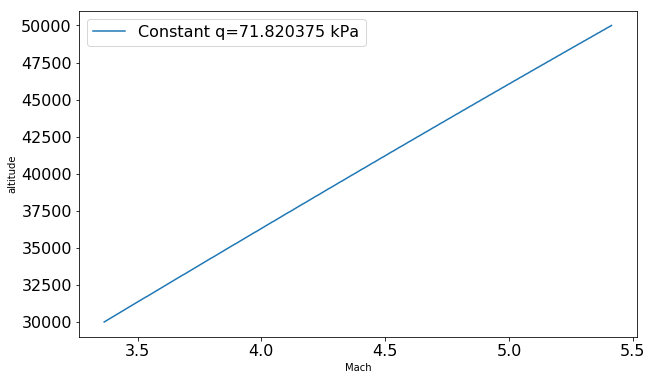

In [7]:
#GRAPHING TIME
plt.figure(figsize=(10,6))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
#
plt.plot(machs,alts,'-',label="Constant q=71.820375 kPa")

#plt.title('Mach number to altitude', fontsize=16)

#plt.ylim(0,1.5)
plt.ylabel('altitude')
plt.xlabel('Mach')
plt.legend(loc=2, fontsize=16)

plt.show()
plt.close()

In [8]:
#Find the index of the mach 5 term
iVal = machs.index(min([abs(item-5) for item in machs])+5)

In [9]:
#Verify that this is, indeed, mach 5
print(machs[iVal])

5.001


In [10]:
#Printing off the data table
data = [["$M_0$","Input","5"],["Alpha","Input","0"],["Beta","Input","0"],
        ["$q_0$","input",71.8],["$H$","Calc",alts[iVal]],
        ["$P_0$","Calc",staticP[iVal]],
        ["$P_{t0}$","Calc",totalP[iVal]],["$T_0$","Calc",staticT[iVal]],
        ["$T_{t0}$","Calc",totalT[iVal]],
        ["$\rho_0$","Calc",densities[iVal]*1000]]
dataColumns = ["NOMENCLATURE","TYPE","Value"] #4
dataRows = ["Flight Mach Number","Angle of Attack ($rad$)","Yaw Angle ($rad$)",
            "Dynamic Pressure ($kPa$)","Altitude ($m$)",
            "Freestream Pressure\n ($kPa$)","Freestream Total Pressure ($kPa$)",
           "Freestream Temperature ($K$)", "Freestream Total Temperature ($K$)",
           "Freestream Density ($g/m^3$)"] #7
pd.DataFrame(data, columns=dataColumns, index=dataRows)


,NOMENCLATURE,TYPE,Value
Flight Mach Number,$M_0$,Input,5
Angle of Attack ($rad$),Alpha,Input,0
Yaw Angle ($rad$),Beta,Input,0
Dynamic Pressure ($kPa$),$q_0$,input,71.8
Altitude ($m$),$H$,Calc,46056.1
Freestream Pressure\n ($kPa$),$P_0$,Calc,135.896
Freestream Total Pressure ($kPa$),$P_{t0}$,Calc,71947.3
Freestream Temperature ($K$),$T_0$,Calc,279.648
Freestream Total Temperature ($K$),$T_{t0}$,Calc,1678.19
Freestream Density ($g/m^3$),$\rho_0$,Calc,1.69411


In [13]:
## PARAMETERS FROM ABOVE ##
T0 = staticT[iVal]
M0 = machs[iVal]
rho0 = densities[iVal]
print("T0:",T0)

mDot1X = 10 / 2.205 #kg/s
mDot5X = mDot1X * 5
print("mdot 5 (kg/s): ",mDot5X)
a = np.sqrt(1.41 * 287 * T0)
u = M0 * a
print(u)
A3X = mDot1X*3 / (u*rho0)
A5X = mDot5X / (u*rho0)
print("A3X: ", np.pi*((19.04*0.0254)/2)**2)
print(A3X)
print(A5X)

T0: 279.648
mdot 5 (kg/s):  22.675736961451246
1682.337858079273
A3X:  0.18369240605439138
4.77372670049954
7.956211167499232


In [24]:
path = os.getcwd()
print(path)
inletFile = pd.read_csv("inletmap.csv")
print(inletFile)

C:\Users\butle175\Downloads\AAE537-master
   Flight Mach Number Angle of Attack (deg) Yaw Angle (deg)  \
0                  M0                 Alpha            Beta   
1               Input                 Input           Input   
2                   4                    -4               0   
3                   4                    -2               0   
4                   4                     0               0   
5                   4                     2               0   
6                   4                     4               0   
7                   4                     6               0   
8                 NaN                   NaN             NaN   
9                 4.5                    -4               0   
10                4.5                    -2               0   
11                4.5                     0               0   
12                4.5                     2               0   
13                4.5                     4               0   
14           